<a href="https://colab.research.google.com/github/Karthik482/Image_classification_using_pytorch/blob/master/Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget -c https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/intro-to-pytorch/helper.py

--2020-05-21 21:47:53--  https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/intro-to-pytorch/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 416 Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [0]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch import optim

In [0]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
  transforms.Normalize((0.5,), (0.5,))
])

#note: transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), 3 values means 3 channels, however for mnist there is only 1 channel, hence transforms.Normalize((0.5,), (0.5,))

In [0]:
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

Batch size should be any base 8 (8X1=8,8x2=16,.....)  .....( No reason for this)

Feed Forward

In [0]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)

        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))

        # output so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)

        return x

In [6]:
model = Classifier()

images, labels = next(iter(testloader))
# Get the class probabilities
ps = torch.exp(model(images))
# Make sure the shape is appropriate, we should get 10 class probabilities for 64 examples
print(ps.shape)

#note: You get error if you dont mention correct normalination for eg.. in transform 2nd chuck of code [(0.5,0.5)]. Mention currectly based on number of  channels. MNSIT has 1 channel

torch.Size([64, 10])


With the probabilities, we can get the most likely class using the ps.topk method. This returns the  𝑘  highest values. Since we just want the most likely class, we can use ps.topk(1). This returns a tuple of the top- 𝑘  values and the top- 𝑘  indices. If the highest value is the fifth element, we'll get back 4 as the index.

FULL MODEL WITH BACKPROPAGATION AND DROPOUT TO AVOID OVERFIT

In [9]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 10
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval()
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        model.train()
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/10..  Training Loss: 0.607..  Test Loss: 0.477..  Test Accuracy: 0.825
Epoch: 2/10..  Training Loss: 0.481..  Test Loss: 0.457..  Test Accuracy: 0.838
Epoch: 3/10..  Training Loss: 0.453..  Test Loss: 0.428..  Test Accuracy: 0.848
Epoch: 4/10..  Training Loss: 0.434..  Test Loss: 0.417..  Test Accuracy: 0.851
Epoch: 5/10..  Training Loss: 0.420..  Test Loss: 0.420..  Test Accuracy: 0.846
Epoch: 6/10..  Training Loss: 0.413..  Test Loss: 0.406..  Test Accuracy: 0.858
Epoch: 7/10..  Training Loss: 0.402..  Test Loss: 0.399..  Test Accuracy: 0.859
Epoch: 8/10..  Training Loss: 0.401..  Test Loss: 0.386..  Test Accuracy: 0.864
Epoch: 9/10..  Training Loss: 0.391..  Test Loss: 0.398..  Test Accuracy: 0.855
Epoch: 10/10..  Training Loss: 0.384..  Test Loss: 0.390..  Test Accuracy: 0.864


In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

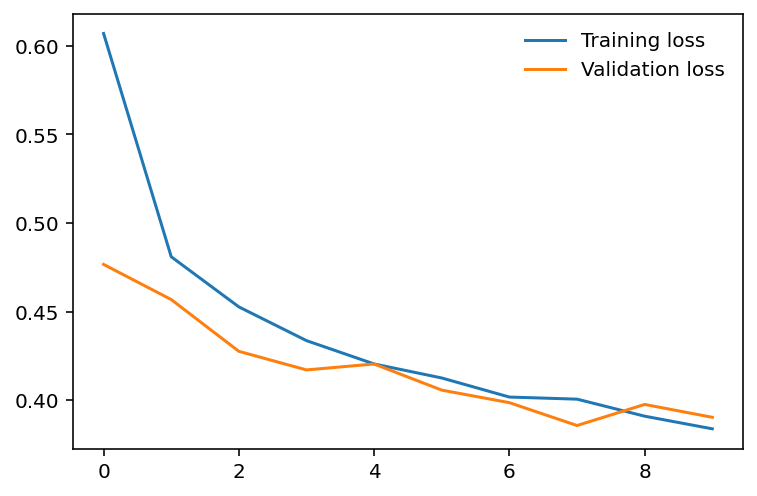

In [11]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

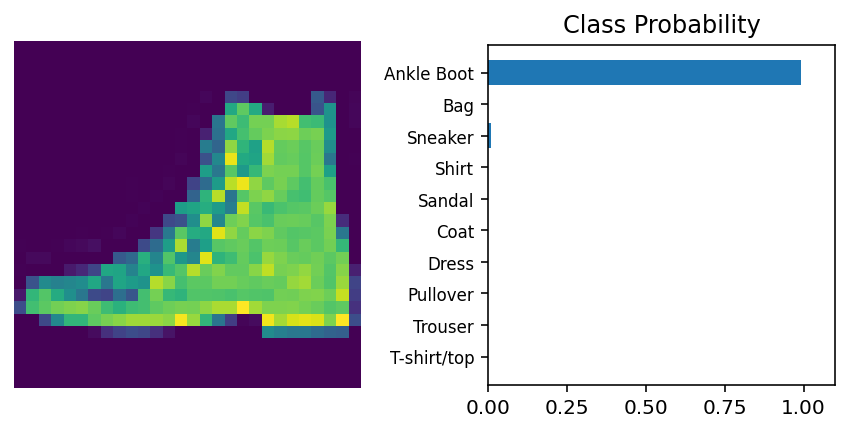

In [13]:
# Import helper module (should be in the repo)
import helper

# Test out your network!

model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)

# Plot the image and probabilities
helper.view_classify(img.view(1, 28, 28), ps, version='Fashion')